## Integrating a simple harmonic oscillator and trying to infer the spring constant

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import InterpolatedUnivariateSpline
import scipy.optimize as so
%matplotlib inline
import autograd.numpy as np  # Thinly-wrapped numpy
from autograd import grad  
import tensorflow as tf
from tensorflow.contrib import autograph
import tfleapfrog_copy as tflf

In [2]:
tf.VERSION

'1.10.0'

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
def genData(x, v, npoints, std_noise_x, std_noise_v):
    noise_x = np.random.normal(0, std_noise_x, len(x))
    noise_v = np.random.normal(0, std_noise_v, len(x))
    return noise_x + x, noise_v + v

In [5]:
def ln_likelihood(theta, data, dt_model):
    chi2 = 0
    k, x0, v0, *t_obs = theta
    x_obs, v_obs, sigma_x, sigma_v = data
    x, v = leapfrog(x0, v0, np.array(t_obs), phi_grad, dt, k=k)
    chi2 += -(v - v_obs)**2 / sigma_v**2 - 2*np.log(sigma_v)
    chi2 += -(x - x_obs)**2 / sigma_x**2 - 2*np.log(sigma_x)
    return 0.5*chi2.sum()

In [6]:
def potential_and_grad_py(position, k=1.0):
    #function that returns the potential and it's gradient at a given position
    return 0.5 * k * position**2, k*position

def leap(position, momentum, grad, potential_and_grad, step_size, k=1.0):
    momentum -= 0.5 * step_size * grad
    position += step_size * momentum
    potential, grad = potential_and_grad_py(position, k=k)
    momentum -= 0.5 * step_size * grad
    return position, momentum, potential, grad

def leapfrog(x0, v0, t_obs, potential_and_grad_py, dt, k=1.0):
    #function that takes initial conditions that takes us to the next position 
    x = [] 
    v = [] 
    t = [] 
    grads = []
    dts  = []
    time = []
    
    tprime = 0.0
    xprime = x0
    vprime = v0
    pot, grad = potential_and_grad_py(xprime, k=k)
    for to in t_obs:

        while tprime + dt < to:
            xprime, vprime, pot, grad = leap(xprime, vprime, grad, potential_and_grad_py, dt, k=k)
            tprime = tprime + dt    
        dt_tiny = to - tprime
        xsave, vsave, potsave, gradsave = leap(xprime, vprime, grad, potential_and_grad_py, dt_tiny, k=k)
        tsave = tprime + dt_tiny
        #print(xsave, vsave, tsave, potsave, gradsave)
        x.append(xsave.copy())
        v.append(vsave.copy())
        t.append(tsave.copy())
        grads.append(grad)
        dts.append(dt_tiny.copy())
        time.append(tprime)
        #print(x, v)
    return np.array(x), np.array(v), np.array(grads), np.array(dts), np.array(time) #, np.array(t)

In [7]:
np.random.seed(1)

In [8]:
x0_true   = 100.
v0_true   = 100.
k_true    = 10.

max_time  = np.float64(10.)

nobspoints = 10
std_noise_x = 10.0
std_noise_v = 10.0

plot_xerr = np.zeros(nobspoints) + std_noise_x
plot_yerr = np.zeros(nobspoints) + std_noise_v
t_obs_true = np.linspace(0, max_time, nobspoints) #np.random.uniform(0, max_time, nobspoints)
t_obs_true.sort()

In [9]:
t_obs_true

array([ 0.        ,  1.11111111,  2.22222222,  3.33333333,  4.44444444,
        5.55555556,  6.66666667,  7.77777778,  8.88888889, 10.        ])

In [25]:
#define step size of each leap and number of shos
s_size = np.float64(0.01)      #resolution of each leap
n_shos = 1            #number of simple harmonic oscillators 

#generate initial velocities and momenta
#
position_value = np.float64(10.0) #np.float64(np.random.randn(n_shos))
momentum_value = np.float64(4.0) #np.float64(np.random.randn(n_shos))

#set spring constant
k_val = np.float64(1.0)
t_previous_value = np.float64(0.0)
x_value = np.float64(0.0)
y_value = np.float64(0.0)
#generate initial times to model SHO
t_obs_init = t_obs_true #np.random.uniform(0, max_time, nobspoints)
t_obs_init.sort()


In [26]:
#generate true values and noisify them
x_true, v_true, grad_true, dt_tiny_true, time_steps_true = leapfrog(x0_true, v0_true, t_obs_true, potential_and_grad_py, s_size, k=k_true)
x_obs, v_obs = genData(x_true, v_true, nobspoints, std_noise_x, std_noise_v)

In [27]:
xleap, vleap, gradleap, dtleap, timeleap = leapfrog(position_value, momentum_value, t_obs_init, potential_and_grad_py, s_size, k=k_val)

def evolve(params, t):
    position_eval, momentum_eval, k, grad_eval, potential_eval, t_previous, x_eval, v_eval = params
    print(t, t_previous)
    deltat = t - t_previous
    print(deltat)
    new_p_eval, new_m_eval, new_p_eval, new_g_eval, new_x_eval, new_v_eval, new_time_step_eval = session.run(
      [position_model, momentum_model, potential_model, grad_model, x_model, v_model, time_on_step_model],
      feed_dict = {position: position_eval, momentum: momentum_eval, k: k, dt: deltat})#, grad:grad_val})
    new_t_previous = t_previous + new_time_step_eval

    params = [new_p_eval, new_m_eval, k, new_g_eval, new_p_eval, new_t_previous, new_x_val, new_v_val]
    return params

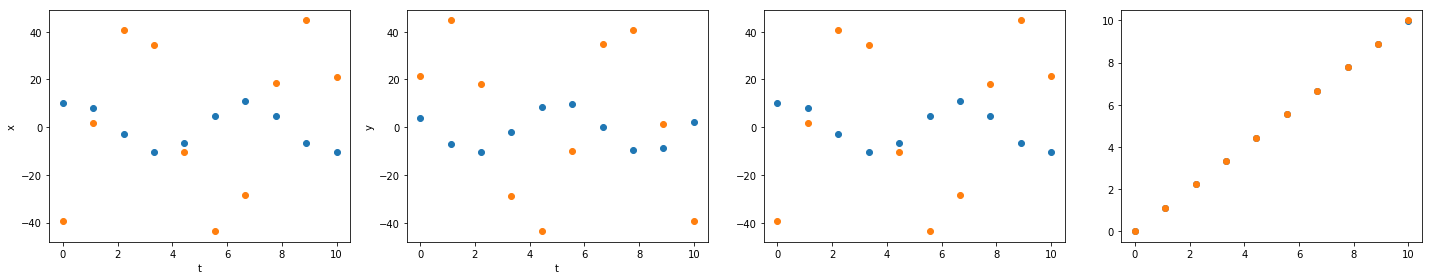

In [32]:
def potential_and_grad(position, k=np.float64(1.0)):
    #function that returns the potential and it's gradient at a given position
    return 0.5 * tf.multiply(k,tf.square(position)), tf.multiply(k,position)


tf.reset_default_graph()


#create placeholders for initial position and momentum, spring constant, and obs times to define model
#there are what the feed dict will expect as inputs
position = tf.get_variable("position", dtype=tf.float64, initializer=tf.constant(position_value))
momentum = tf.get_variable("momentum", dtype=np.float64, initializer=tf.constant(momentum_value))
k        = tf.get_variable("k"         , dtype=np.float64, initializer=tf.constant(k_val))
t_obs    = tf.get_variable("t_obs"     , dtype=np.float64, initializer=tf.constant(t_obs_init))    
    
dt       = tf.get_variable("dt"        , dtype=np.float64, initializer=tf.constant(np.float64(0.0)))
#dt = tf.placeholder(np.float64, name='dt')
step_size = tf.constant(0.01, dtype=np.float64) #tf.placeholder(np.float32, name='step_size')
t_previous = tf.get_variable('tprevious', dtype=tf.float64, initializer = tf.constant(np.float64(0.0)))
x         = tf.get_variable("x",         dtype=tf.float64, initializer = tf.constant(np.float64(0.0)))
v         = tf.get_variable("v",         dtype=tf.float64, initializer = tf.constant(np.float64(0.0)))


#new_ means model which you generated with placeholders, _val means instantiated value where you feed in param values

#define potential

potential_model, grad_model = potential_and_grad(position, k=k)

#define model, leapfrog_integrator is from hmc tensorflow stuff

#position_model, momentum_model, potential_model, grad_model, x_model, v_model, time_on_step_model = tflf.leapfrog_integrator(
#    step_size, dt, position, momentum, potential_and_grad, grad_model)

model_leap = tflf.leapfrog_integrator(step_size, dt, position, momentum, potential_and_grad, grad_model)

#generate arrays to save values from model
positions = np.zeros([nobspoints, n_shos])
momenta   = np.zeros([nobspoints, n_shos])
grad      = np.zeros([nobspoints, n_shos])
potential = np.zeros([nobspoints, n_shos])
dt_tf     = np.zeros([nobspoints, n_shos])
time_step = np.zeros([nobspoints, n_shos])
#start session

with tf.Session() as session:
    # This step is needed to set up the variables.
    session.run(tf.global_variables_initializer())
    
    # And compute the log likelihood.
    #print("The log likelihood computed using tensorflow: {0}"
    #      .format(session.run(log_like)))

    #calculate potential and gradient at these random positions 
    potential_eval, grad_eval = session.run([potential_model, grad_model])#,
                                 #feed_dict={position: position_value, k: k_val})


    #run model on random initial positions and momenta
    t_previous = 0.0
    for i, t in enumerate(t_obs_init):

        deltat = np.float64(t - t_previous)
        position_value, momentum_value, potential_value, grad_value, x_value, v_value, time_step_value = session.run(
            model_leap, feed_dict = {dt: deltat, position:position_value, momentum:momentum_value})
            #model_leap, feed_dict = {position: position_value, momentum: momentum_value, k: k_val, dt: deltat})
        positions[i] = x_value
        momenta[i] = v_value
        grad[i] = grad_value
        potential[i] = potential_value
        t_previous = t_previous + time_step_value
        time_step[i] = t_previous
        
# Plot positions and momenta 
#print(positions, momenta)
fig, ax = plt.subplots(1,4, figsize=(20, 4))
ax[0].plot(t_obs_init, xleap, 'o')
ax[0].plot(t_obs_init, positions, 'o')
ax[0].set_xlabel('t')
ax[0].set_ylabel('x')
ax[1].set_xlabel('t')
ax[1].set_ylabel('y')
ax[1].plot(t_obs_init, vleap, 'o')
ax[1].plot(t_obs_init, momenta, 'o')
ax[2].plot(t_obs_init, gradleap, 'o')
ax[2].plot(t_obs_init, grad, 'o')
ax[3].plot(t_obs_init, time_step, 'o')
ax[3].plot(t_obs_init, timeleap, 'o')
plt.legend()
plt.tight_layout()

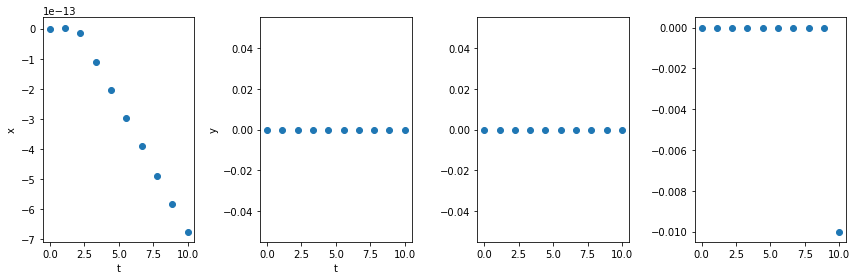

In [14]:
# Plot positions and momenta 
fig, ax = plt.subplots(1,4, figsize=(12, 4))
ax[0].plot(t_obs_init, positions.T[0] - xleap.T, 'o')

ax[0].set_xlabel('t')
ax[0].set_ylabel('x')
ax[1].set_xlabel('t')
ax[1].set_ylabel('y')
ax[1].plot(t_obs_init, momenta.T[0] - vleap.T, 'o')
ax[2].plot(t_obs_init, grad.T[0] - gradleap.T, 'o')
ax[3].plot(t_obs_init, time_step.T[0] - timeleap.T, 'o')
plt.tight_layout()

Text(0,0.5,'Small Step TF - Small Step Leap')

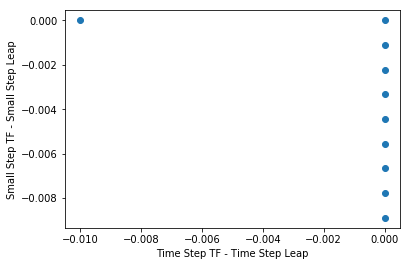

In [15]:
plt.plot(time_step.T[0] - timeleap.T, dt_tf.T[0] - dtleap.T, 'o')
plt.xlabel('Time Step TF - Time Step Leap')
plt.ylabel('Small Step TF - Small Step Leap')

In [16]:
true_tiny_t = t_obs_init % s_size

In [17]:
t_obs_init

array([ 0.        ,  1.11111111,  2.22222222,  3.33333333,  4.44444444,
        5.55555556,  6.66666667,  7.77777778,  8.88888889, 10.        ])

In [18]:
time_step.T + dt_tf.T

array([[0.  , 1.11, 2.22, 3.33, 4.44, 5.55, 6.66, 7.77, 8.88, 9.99]])

In [19]:
0.0011437481734488664
0.9222421995145291
0.5441729604831524
0.3950432056055786
1.1607236125416887
0.43228154411208
0.5120674718762217
0.20254530471904086
1.2179472930078292
1.8150775943880113

1.8150775943880113

In [20]:
true_tiny_t - dt_tf.T

array([[0.        , 0.00111111, 0.00222222, 0.00333333, 0.00444444,
        0.00555556, 0.00666667, 0.00777778, 0.00888889, 0.01      ]])

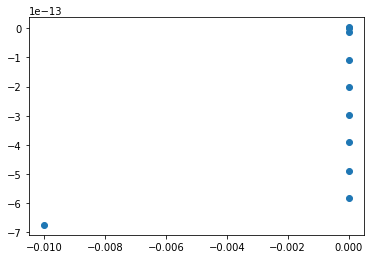

In [21]:
plt.plot(time_step.T[0] - timeleap.T, positions.T[0] - xleap.T, 'o')

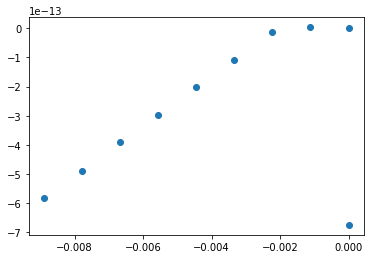

In [22]:
plt.plot(dt_tf.T[0] - dtleap.T, positions.T[0] - xleap.T, 'o')

In [23]:
xleap.T

array([10.        , 14.44444444, 18.88888889, 23.33333333, 27.77777778,
       32.22222222, 36.66666667, 41.11111111, 45.55555556, 50.        ])

In [24]:
position_val

NameError: name 'position_val' is not defined

In [35]:
import tensorflow as tf

def scoping(fn, scope1, scope2, vals):
    with fn(scope1):
        a = tf.Variable(vals[0], name='a')
        b = tf.get_variable('b', initializer=vals[1])
        c = tf.constant(vals[2], name='c')

        with fn(scope2):
            d = tf.add(a * b, c, name='res')

        print('\n  '.join([scope1, a.name, b.name, c.name, d.name]), '\n')
    return d

d1 = scoping(tf.variable_scope, 'scope_vars', 'res', [1, 2, 3])
d2 = scoping(tf.name_scope,     'scope_name', 'res', [1, 2, 3])

with tf.Session() as sess:
    writer = tf.summary.FileWriter('logs', sess.graph)
    sess.run(tf.global_variables_initializer())
    print(sess.run([d1, d2]))
    writer.close()

scope_vars
  scope_vars/a:0
  scope_vars/b:0
  scope_vars/c:0
  scope_vars/res/res:0 

scope_name
  scope_name/a:0
  b:0
  scope_name/c:0
  scope_name/res/res:0 

[5, 5]


# License: See LICENSE
# Fit a straight line, of the form y=m*x+b

import tensorflow as tf
import numpy as np

'''
Your dataset.
'''
xs = np.linspace(0.0, 8.0, 8000000) # 8-million features
ys = 0.3*xs-0.8+np.random.normal(scale=0.25, size=len(xs)) # 8-million labels

'''
Initial guesses, which will be refined by TensorFlow.
'''
m_initial = -0.5 # Initial guesses
b_initial =  1.0

'''
Define free variables to be solved.
'''
m = tf.Variable(m_initial) # Parameters
b = tf.Variable(b_initial)

'''
Define placeholders for big data.
'''
_BATCH = 8 # Use only eight points at a time.
xs_placeholder = tf.placeholder(tf.float32, [_BATCH])
ys_placeholder = tf.placeholder(tf.float32, [_BATCH]) 

'''
Define the error between the data and the model as a tensor (distributed computing).
'''
ys_model = m*xs_placeholder+b # Tensorflow knows this is a vector operation
total_error = tf.reduce_sum((ys_placeholder-ys_model)**2) # Sum up every item in the vector

'''
Once cost function is defined, create gradient descent optimizer.
'''
optimizer_operation = tf.train.GradientDescentOptimizer(learning_rate=0.001).minimize(total_error) # Does one step

'''
Create operator for initialization.
'''
initializer_operation = tf.global_variables_initializer()

'''
All calculations are done in a session.
'''
with tf.Session() as session:

	session.run(initializer_operation) # Call operator

	_EPOCHS = 10000 # Number of "sweeps" across data
	for iteration in range(_EPOCHS):
		random_indices = np.random.randint(len(xs), size=_BATCH) # Randomly sample the data
		feed = {
			xs_placeholder: xs[random_indices],
			ys_placeholder: ys[random_indices]
		}
		session.run(optimizer_operation, feed_dict=feed) # Call operator

	slope, intercept = session.run((m, b)) # Call "m" and "b", which are operators
	print('Slope:', slope, 'Intercept:', intercept)

In [ ]:
print(autograph.to_code(leapfrog))